In [1]:
from IPython.display import display
from IPython.display import clear_output
import PIL
import numpy as np
import time
import os
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import gc
import sys
import seaborn as sns
import tensorflow as tf
import tensorlayer as tl

In [2]:
tf.reset_default_graph()

In [3]:
tf.logging.set_verbosity(tf.logging.DEBUG)

In [4]:
SCALAR = 80

In [5]:
raw_RAD_id_list = os.listdir('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/')
print(len(raw_RAD_id_list))

5000


In [6]:
def check_RAD_id(RAD_id):
    sum_list = []
    for k in range(61):
        sum_list.append(np.array(PIL.Image.open('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png'
                         % (RAD_id, RAD_id,
                        k))).astype(np.int8).ravel().sum())
    sum_list = np.array(sum_list)
    if i % 100 == 0:
        print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
        print(i, sum_list[:7])
    if sum_list.mean() < 251001 * 0:
        return False
    for k in range(59):
        if abs(sum_list[k] + sum_list[k + 2] - 2 * sum_list[k + 1]) > 251001 * 2:
            return False
    return True

In [7]:
RAD_id_list = raw_RAD_id_list

In [8]:
start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
RAD_id_list = []
for (i, RAD_id) in enumerate(raw_RAD_id_list[:100]):
    if check_RAD_id(RAD_id):
        RAD_id_list.append(RAD_id)
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
print(len(RAD_id_list))

start time: 2018-08-21 20:24:30
00:00:00
0 [-218731 -223051 -219804 -220007 -214895 -215379 -215980]
end time: 2018-08-21 20:24:34
00:00:04
36


In [9]:
def read_by_RAD_id(RAD_id, offset):
    x_matrix = np.empty((31, 501, 501, 1))
    for i in range(31):
        x_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i + offset))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
    y_matrix = np.empty((501, 501, 1))
    y_matrix = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 31 + offset))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
    return ([x_matrix], [y_matrix])

In [16]:
all_start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
# sess.close()
# with tf.device("/gpu:0"):
tf.reset_default_graph()
sess = tf.InteractiveSession()

# define placeholder
x = tf.placeholder(tf.float32, shape=[None, 31, 501, 501, 1], name='x')
y_ = tf.placeholder(tf.float32, shape=[None, 501, 501, 1], name='y_')

# define the network
# network = tl.layers.InputLayer(x, name='input')
network = x
network = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=x.shape, padding='same', return_sequences=False, dropout=0.8, recurrent_dropout=0.9)(network)
network = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same')(network)

y = network
# cost = tf.losses.mean_squared_error(y, y_, weights=y_)
cost = tf.losses.mean_squared_error(y, y_)

train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

sess.run(tf.global_variables_initializer())

n_epoch = 20
print_freq = 5

sum_cost = 0
for epoch in range(n_epoch):
    for i in range(1):
        for j in range(0, 10, 3):
            X_train, Y_train = read_by_RAD_id(RAD_id_list[i], j)
            feed_dict = {x: X_train, y_: Y_train}
        #     feed_dict.update(network.all_drop)  # enable noise layers
            train_cost, _ = sess.run([cost, train_op], feed_dict=feed_dict)
            sum_cost += train_cost / (Y_train[0].sum() + 251001)
        if i % print_freq == 0:
            print('%3d'%epoch, '%3d'%i, RAD_id_list[i], '%3d'%j, time.strftime('%H:%M:%S', time.localtime()), time.strftime('%H:%M:%S', time.gmtime(time.time() - all_start_time)), '%5.5f'%(sum_cost * 10 ** 10))
        sum_cost = 0

start time: 2018-08-21 20:55:34
  0   0 RAD_346482464229534   9 20:55:48 00:00:13 1415.27380
  1   0 RAD_346482464229534   9 20:56:00 00:00:25 1073.73844
  2   0 RAD_346482464229534   9 20:56:13 00:00:38 900.30481
  3   0 RAD_346482464229534   9 20:56:25 00:00:50 828.73464
  4   0 RAD_346482464229534   9 20:56:38 00:01:03 756.93879
  5   0 RAD_346482464229534   9 20:56:50 00:01:15 714.13725
  6   0 RAD_346482464229534   9 20:57:03 00:01:28 677.89836
  7   0 RAD_346482464229534   9 20:57:15 00:01:40 651.95061
  8   0 RAD_346482464229534   9 20:57:27 00:01:53 630.43740
  9   0 RAD_346482464229534   9 20:57:40 00:02:05 611.98831
 10   0 RAD_346482464229534   9 20:57:52 00:02:18 598.02490
 11   0 RAD_346482464229534   9 20:58:05 00:02:30 584.64262
 12   0 RAD_346482464229534   9 20:58:17 00:02:43 572.93311
 13   0 RAD_346482464229534   9 20:58:30 00:02:55 561.75600
 14   0 RAD_346482464229534   9 20:58:42 00:03:07 551.14226
 15   0 RAD_346482464229534   9 20:58:55 00:03:20 541.10163
 16   

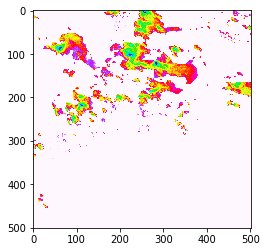

↓↓↓下面的是模型的1输出，上面的是1真实值↑↑↑


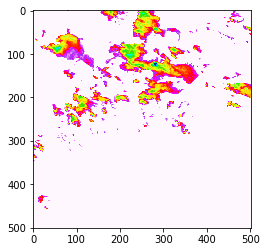


------------------------------------



In [12]:
feed_dict = {x: X_train}
prediction = sess.run(y, feed_dict=feed_dict)
prediction = prediction[0] * SCALAR
Y_validation = Y_train[0] * SCALAR
plt.imshow(Y_validation.reshape((501,501)), cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是模型的%d输出，上面的是%d真实值↑↑↑' % (1, 1))
prediction = np.where(prediction<3, -1, prediction)
plt.imshow(prediction.reshape((501,501)), cmap=cm.gist_ncar_r)
plt.show()
print('\n------------------------------------\n')

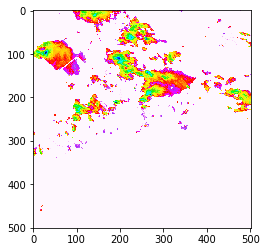

↓↓↓第0序列，第0次，下面的是模型的输出，上面的是真实值↑↑↑


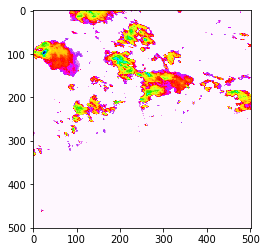


------------------------------------



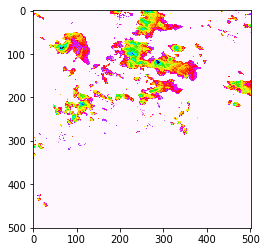

↓↓↓第0序列，第7次，下面的是模型的输出，上面的是真实值↑↑↑


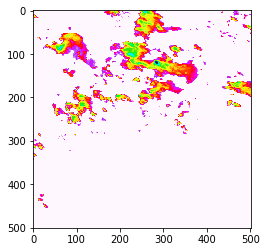


------------------------------------



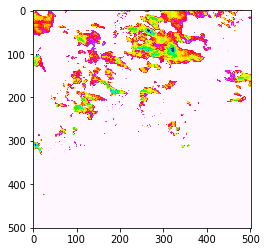

↓↓↓第0序列，第14次，下面的是模型的输出，上面的是真实值↑↑↑


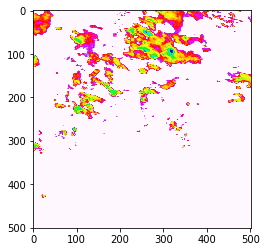


------------------------------------



In [13]:
for i in range(1):
    for j in range(0, 20, 7):
        X_train, Y_train = read_by_RAD_id(RAD_id_list[i], j)
        feed_dict = {x: X_train}
        prediction = sess.run(y, feed_dict=feed_dict)
        prediction = prediction[0] * SCALAR
        Y_validation = Y_train[0] * SCALAR
        plt.imshow(Y_validation.reshape((501,501)), cmap=cm.gist_ncar_r)
        plt.show()
        print('↓↓↓第%d序列，第%d次，下面的是模型的输出，上面的是真实值↑↑↑' % (i, j))
        prediction = np.where(prediction<3, -1, prediction)
        plt.imshow(prediction.reshape((501,501)), cmap=cm.gist_ncar_r)
        plt.show()
        print('\n------------------------------------\n')

In [ ]:
def read_by_RAD_id(RAD_id, offset):
    x_matrix = np.empty((31, 501, 501, 1))
    for i in range(31):
        x_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i + offset))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
    y_matrix = np.empty((501, 501, 1))
    y_matrix = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 31 + offset))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
    return ([x_matrix], [y_matrix])

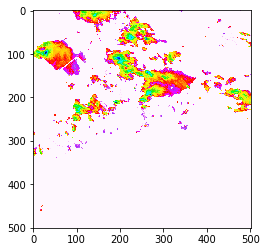

↓↓↓第0序列，第0次，下面的是模型的输出，上面的是真实值↑↑↑


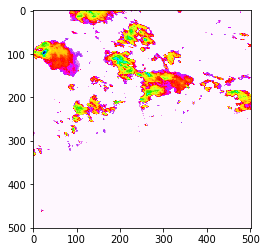


------------------------------------



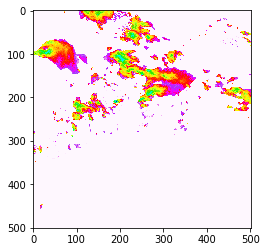

↓↓↓第0序列，第1次，下面的是模型的输出，上面的是真实值↑↑↑


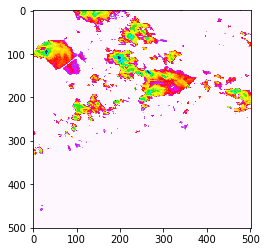


------------------------------------



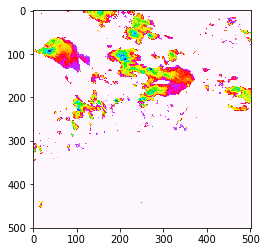

↓↓↓第0序列，第2次，下面的是模型的输出，上面的是真实值↑↑↑


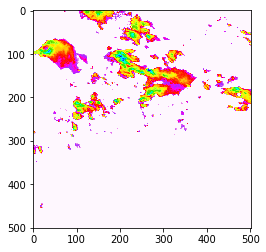


------------------------------------



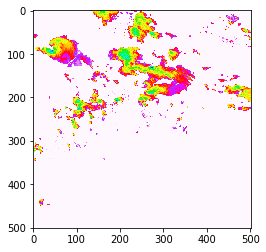

↓↓↓第0序列，第3次，下面的是模型的输出，上面的是真实值↑↑↑


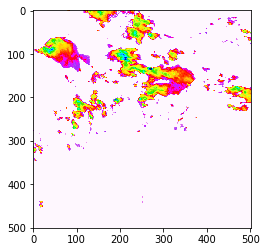


------------------------------------



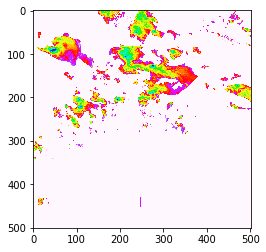

↓↓↓第0序列，第4次，下面的是模型的输出，上面的是真实值↑↑↑


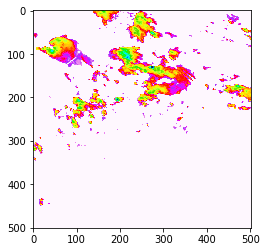


------------------------------------



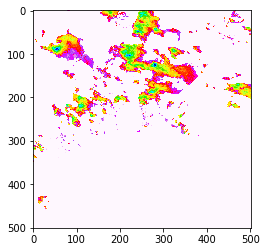

↓↓↓第0序列，第5次，下面的是模型的输出，上面的是真实值↑↑↑


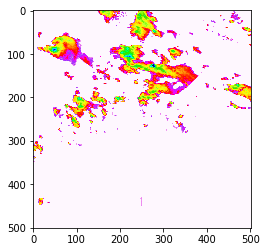


------------------------------------



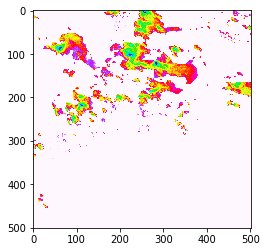

↓↓↓第0序列，第6次，下面的是模型的输出，上面的是真实值↑↑↑


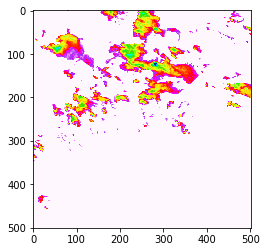


------------------------------------



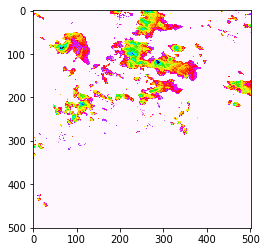

↓↓↓第0序列，第7次，下面的是模型的输出，上面的是真实值↑↑↑


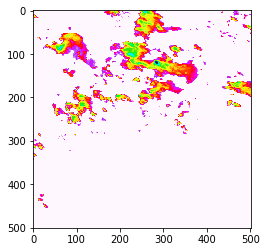


------------------------------------



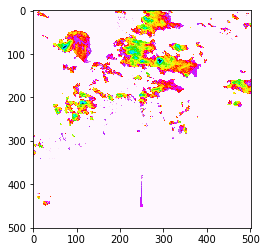

↓↓↓第0序列，第8次，下面的是模型的输出，上面的是真实值↑↑↑


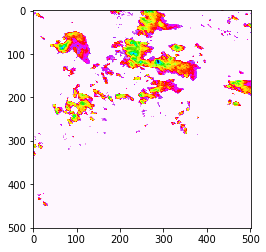


------------------------------------



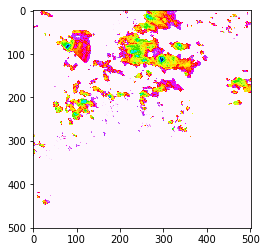

↓↓↓第0序列，第9次，下面的是模型的输出，上面的是真实值↑↑↑


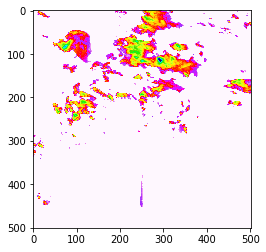


------------------------------------



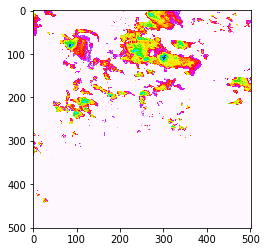

↓↓↓第0序列，第10次，下面的是模型的输出，上面的是真实值↑↑↑


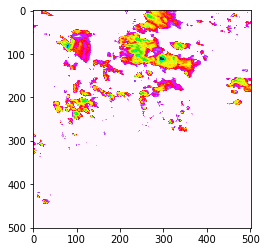


------------------------------------



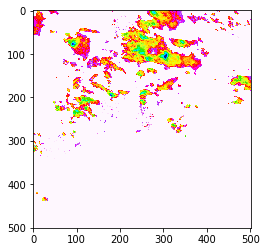

↓↓↓第0序列，第11次，下面的是模型的输出，上面的是真实值↑↑↑


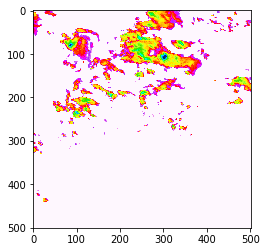


------------------------------------



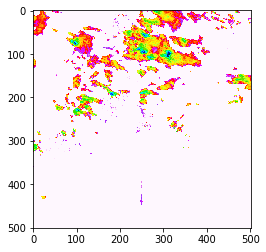

↓↓↓第0序列，第12次，下面的是模型的输出，上面的是真实值↑↑↑


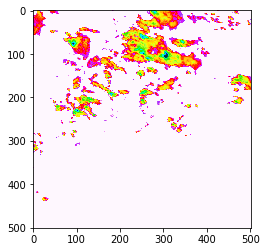


------------------------------------



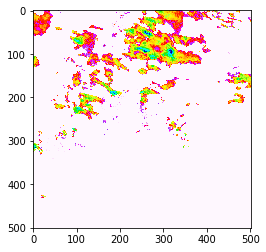

↓↓↓第0序列，第13次，下面的是模型的输出，上面的是真实值↑↑↑


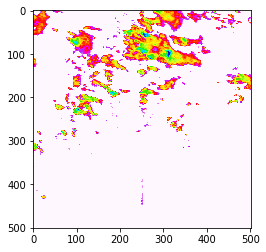


------------------------------------



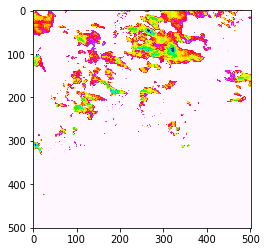

↓↓↓第0序列，第14次，下面的是模型的输出，上面的是真实值↑↑↑


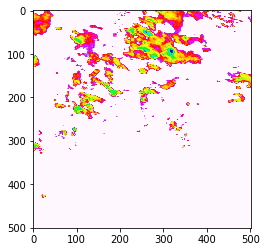


------------------------------------



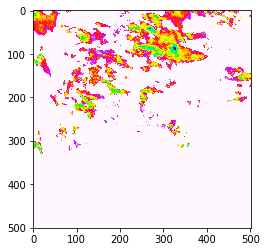

↓↓↓第0序列，第15次，下面的是模型的输出，上面的是真实值↑↑↑


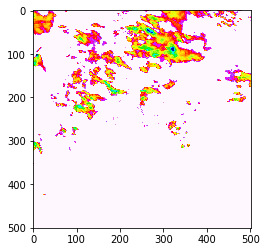


------------------------------------



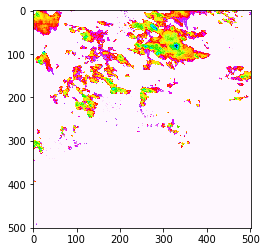

↓↓↓第0序列，第16次，下面的是模型的输出，上面的是真实值↑↑↑


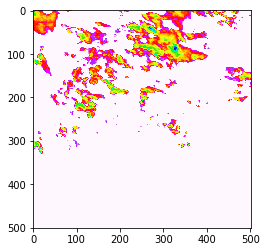


------------------------------------



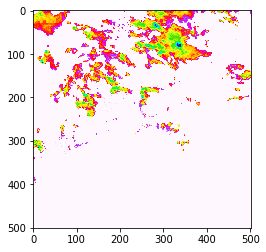

↓↓↓第0序列，第17次，下面的是模型的输出，上面的是真实值↑↑↑


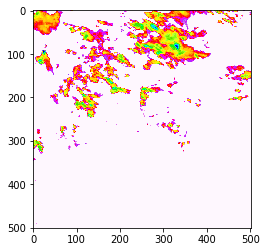


------------------------------------



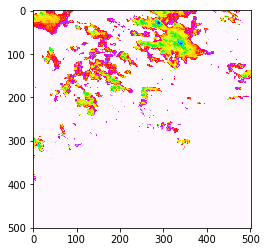

↓↓↓第0序列，第18次，下面的是模型的输出，上面的是真实值↑↑↑


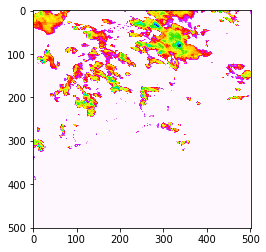


------------------------------------



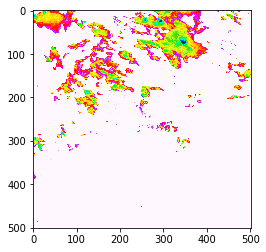

↓↓↓第0序列，第19次，下面的是模型的输出，上面的是真实值↑↑↑


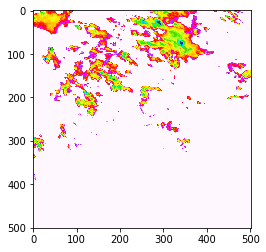


------------------------------------



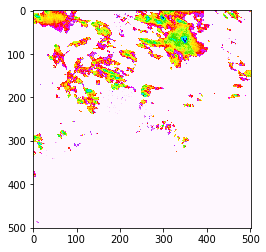

↓↓↓第0序列，第20次，下面的是模型的输出，上面的是真实值↑↑↑


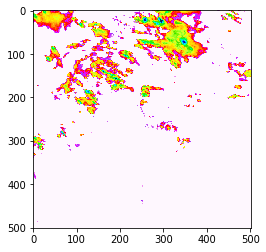


------------------------------------



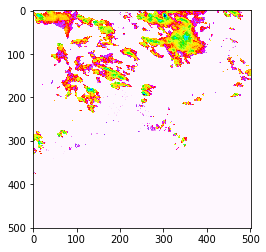

↓↓↓第0序列，第21次，下面的是模型的输出，上面的是真实值↑↑↑


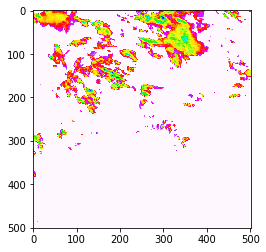


------------------------------------



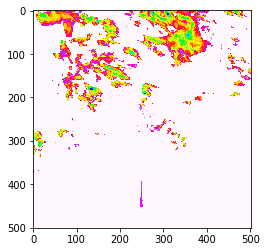

↓↓↓第0序列，第22次，下面的是模型的输出，上面的是真实值↑↑↑


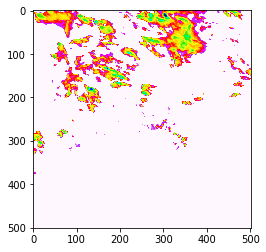


------------------------------------



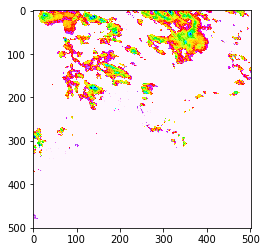

↓↓↓第0序列，第23次，下面的是模型的输出，上面的是真实值↑↑↑


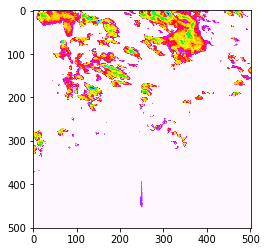


------------------------------------



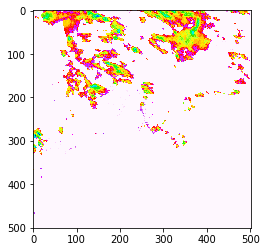

↓↓↓第0序列，第24次，下面的是模型的输出，上面的是真实值↑↑↑


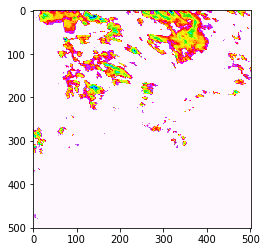


------------------------------------



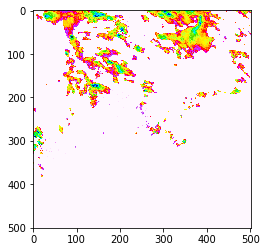

↓↓↓第0序列，第25次，下面的是模型的输出，上面的是真实值↑↑↑


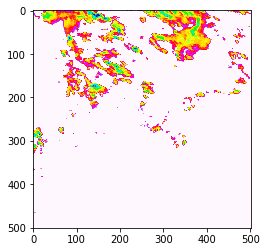


------------------------------------



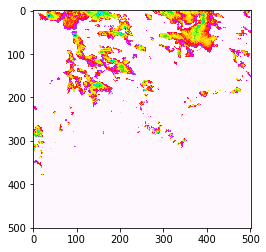

↓↓↓第0序列，第26次，下面的是模型的输出，上面的是真实值↑↑↑


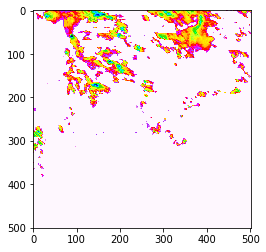


------------------------------------



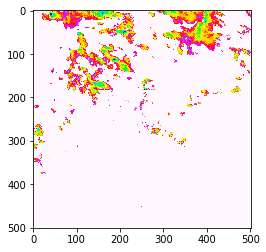

↓↓↓第0序列，第27次，下面的是模型的输出，上面的是真实值↑↑↑


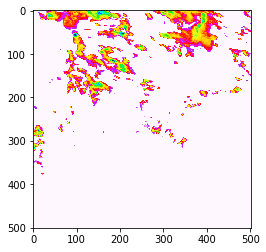


------------------------------------



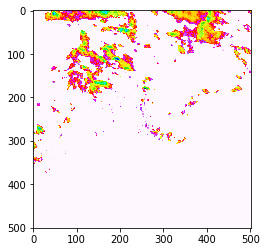

↓↓↓第0序列，第28次，下面的是模型的输出，上面的是真实值↑↑↑


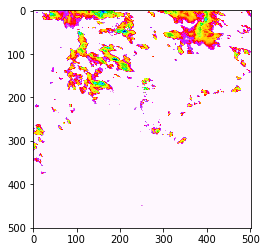


------------------------------------



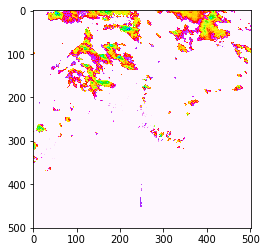

↓↓↓第0序列，第29次，下面的是模型的输出，上面的是真实值↑↑↑


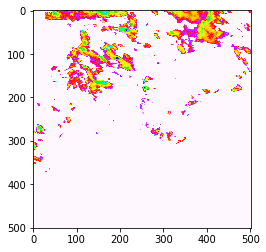


------------------------------------



In [14]:
for i in range(1):
    RAD_id = RAD_id_list[i]
    
    for j in range(30):
        x_matrix = np.empty((31, 501, 501, 1))
        for k in range(31):
            x_matrix[k] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, k + j))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
        feed_dict = {x: [x_matrix]}
        prediction = sess.run(y, feed_dict=feed_dict)
        prediction = prediction[0] * SCALAR
        y_matrix = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 31 + j))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
        plt.imshow(y_matrix.reshape((501,501)), cmap=cm.gist_ncar_r)
        plt.show()
        print('↓↓↓第%d序列，第%d次，下面的是模型的输出，上面的是真实值↑↑↑' % (i, j))
        prediction = np.where(prediction<3, -1, prediction)
        plt.imshow(prediction.reshape((501,501)), cmap=cm.gist_ncar_r)
        plt.show()
        print('\n------------------------------------\n')

In [25]:
prediction.ravel()

array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)

In [61]:
all_start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
# sess.close()
# with tf.device("/gpu:0"):
tf.reset_default_graph()
sess = tf.InteractiveSession()

# define placeholder
x = tf.placeholder(tf.float32, shape=[None, 31, 501, 501, 1], name='x')
y_ = tf.placeholder(tf.float32, shape=[None, 501, 501, 1], name='y_')

# define the network
# network = tl.layers.InputLayer(x, name='input')
network = x
network = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), input_shape=x.shape, padding='same', return_sequences=False, dropout=0.8, recurrent_dropout=0.9)(network)
network = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same')(network)

y = network
# cost = tf.losses.mean_squared_error(y, y_, weights=y_)
w = tf.add(tf.constant(0.2), y_)
w = tf.add(w, y)
cost = tf.losses.mean_squared_error(y, y_, weights=w)
# cost = tf.losses.mean_squared_error(y, y_)

train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
# train_op = tf.train.GradientDescentOptimizer(learning_rate=0.003).minimize(cost)

sess.run(tf.global_variables_initializer())

n_epoch = 20
print_freq = 5

sum_cost = 0
for epoch in range(n_epoch):
    for i in range(1):
        RAD_id = RAD_id_list[i]
        x_matrix = np.empty((31, 501, 501, 1))
        for k in range(30):
            x_matrix[k + 1] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, k))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
        prediction = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 30))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
        for j in range(1):
            for k in range(30):
                x_matrix[k] = x_matrix[k + 1]
            x_matrix[30] = prediction
            
            feed_dict = {x: [x_matrix], y_: [y_matrix]}
            train_cost, _ = sess.run([cost, train_op], feed_dict=feed_dict)
            sum_cost += train_cost / (y_matrix.sum() + 251001)
            if i % print_freq == 0:
                print('%3d'%epoch, '%3d'%i, RAD_id_list[i], '%3d'%j, time.strftime('%H:%M:%S', time.localtime()), time.strftime('%H:%M:%S', time.gmtime(time.time() - all_start_time)), '%5.5f'%(sum_cost * 10 ** 10))
                sum_cost = 0
                
            feed_dict = {x: [x_matrix]}
            prediction = sess.run(y, feed_dict=feed_dict)
            prediction = prediction[0] * SCALAR
            y_matrix = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 31 + j))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
#             plt.imshow(y_matrix.reshape((501,501)), cmap=cm.gist_ncar_r)
#             plt.show()
#             print('↓↓↓第%d序列，第%d次，下面的是模型的输出，上面的是真实值↑↑↑' % (i, j))
            prediction = np.where(prediction<3, -1, prediction)
#             plt.imshow(prediction.reshape((501,501)), cmap=cm.gist_ncar_r)
#             plt.show()
#             print('\n------------------------------------\n')
            prediction = prediction / SCALAR


start time: 2018-08-22 18:44:24
  0   0 RAD_346482464229534   0 18:44:29 00:00:05 149.69760
  1   0 RAD_346482464229534   0 18:44:34 00:00:10 184.38781
  2   0 RAD_346482464229534   0 18:44:39 00:00:14 138.01659
  3   0 RAD_346482464229534   0 18:44:43 00:00:19 194.46817
  4   0 RAD_346482464229534   0 18:44:48 00:00:24 117.54030
  5   0 RAD_346482464229534   0 18:44:53 00:00:29 119.89530
  6   0 RAD_346482464229534   0 18:44:57 00:00:33 122.44616
  7   0 RAD_346482464229534   0 18:45:02 00:00:38 119.85368
  8   0 RAD_346482464229534   0 18:45:07 00:00:43 112.93973
  9   0 RAD_346482464229534   0 18:45:12 00:00:47 103.47130
 10   0 RAD_346482464229534   0 18:45:16 00:00:52 96.09943
 11   0 RAD_346482464229534   0 18:45:21 00:00:57 100.65743
 12   0 RAD_346482464229534   0 18:45:26 00:01:02 95.31133
 13   0 RAD_346482464229534   0 18:45:31 00:01:07 88.13932
 14   0 RAD_346482464229534   0 18:45:35 00:01:11 85.08586
 15   0 RAD_346482464229534   0 18:45:40 00:01:16 83.93463
 16   0 RAD_3

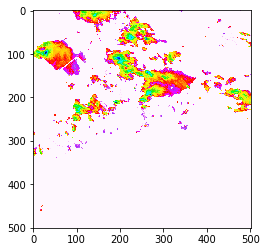

↓↓↓第0序列，第0次，下面的是模型的输出，上面的是真实值↑↑↑


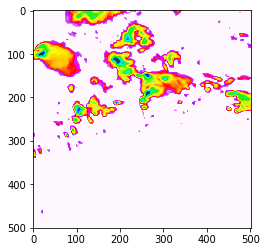


------------------------------------



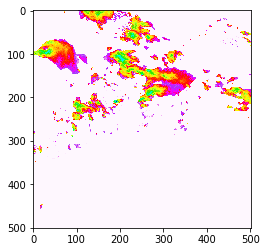

↓↓↓第0序列，第1次，下面的是模型的输出，上面的是真实值↑↑↑


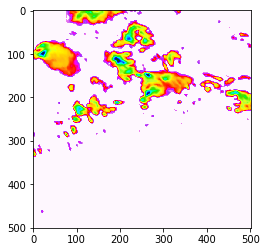


------------------------------------



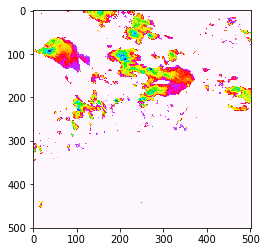

↓↓↓第0序列，第2次，下面的是模型的输出，上面的是真实值↑↑↑


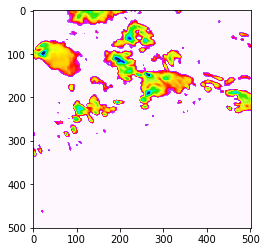


------------------------------------



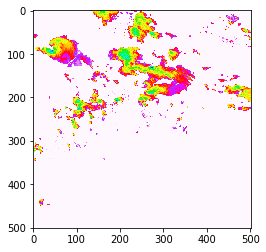

↓↓↓第0序列，第3次，下面的是模型的输出，上面的是真实值↑↑↑


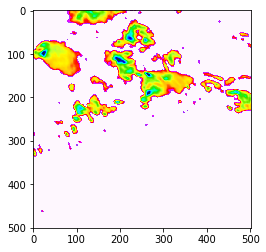


------------------------------------



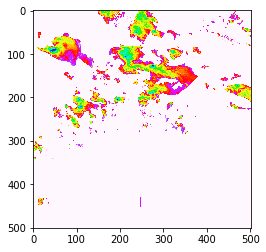

↓↓↓第0序列，第4次，下面的是模型的输出，上面的是真实值↑↑↑


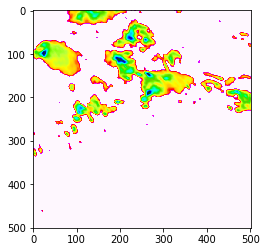


------------------------------------



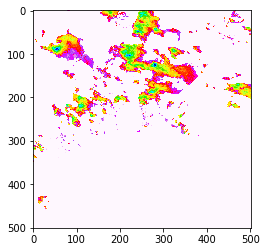

↓↓↓第0序列，第5次，下面的是模型的输出，上面的是真实值↑↑↑


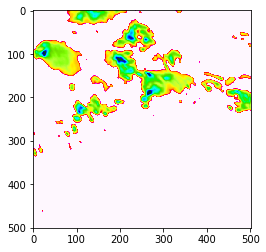


------------------------------------



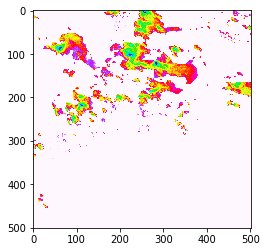

↓↓↓第0序列，第6次，下面的是模型的输出，上面的是真实值↑↑↑


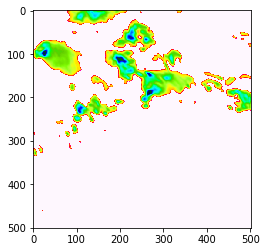


------------------------------------



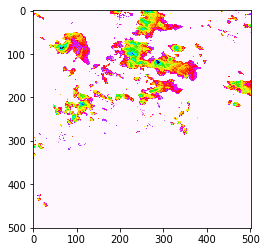

↓↓↓第0序列，第7次，下面的是模型的输出，上面的是真实值↑↑↑


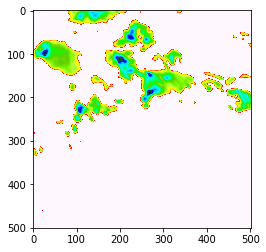


------------------------------------



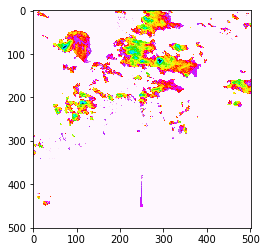

↓↓↓第0序列，第8次，下面的是模型的输出，上面的是真实值↑↑↑


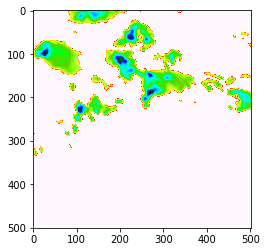


------------------------------------



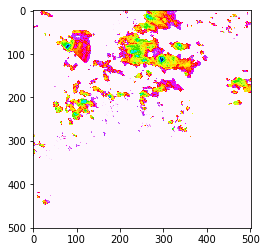

↓↓↓第0序列，第9次，下面的是模型的输出，上面的是真实值↑↑↑


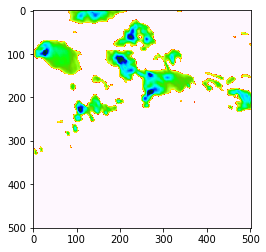


------------------------------------



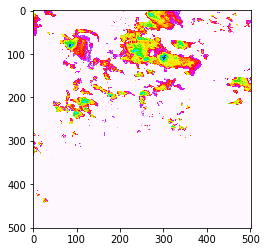

↓↓↓第0序列，第10次，下面的是模型的输出，上面的是真实值↑↑↑


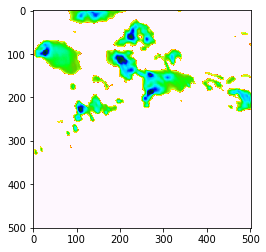


------------------------------------



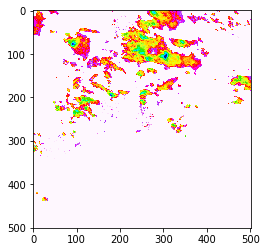

↓↓↓第0序列，第11次，下面的是模型的输出，上面的是真实值↑↑↑


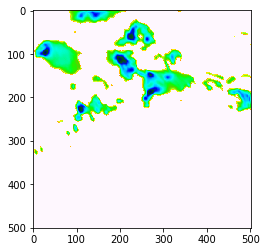


------------------------------------



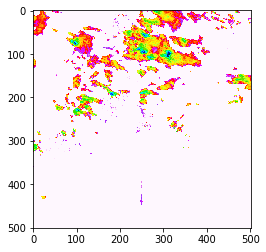

↓↓↓第0序列，第12次，下面的是模型的输出，上面的是真实值↑↑↑


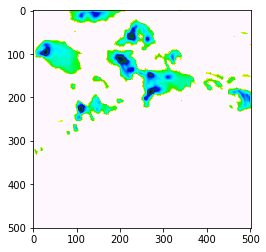


------------------------------------



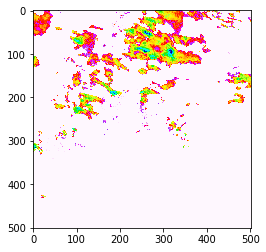

↓↓↓第0序列，第13次，下面的是模型的输出，上面的是真实值↑↑↑


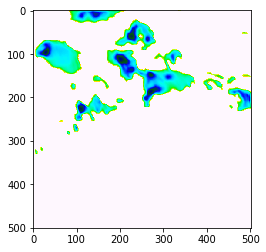


------------------------------------



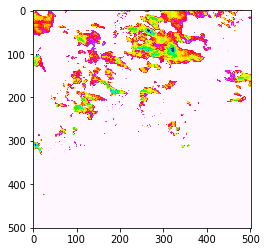

↓↓↓第0序列，第14次，下面的是模型的输出，上面的是真实值↑↑↑


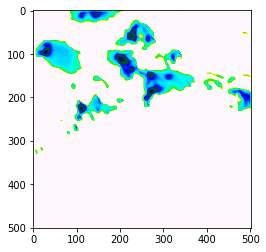


------------------------------------



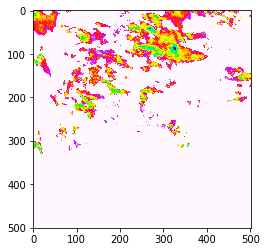

↓↓↓第0序列，第15次，下面的是模型的输出，上面的是真实值↑↑↑


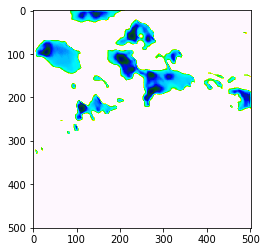


------------------------------------



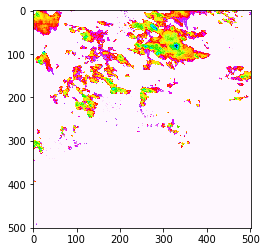

↓↓↓第0序列，第16次，下面的是模型的输出，上面的是真实值↑↑↑


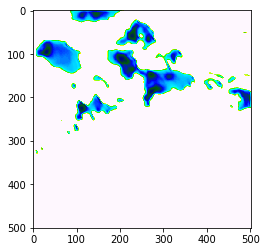


------------------------------------



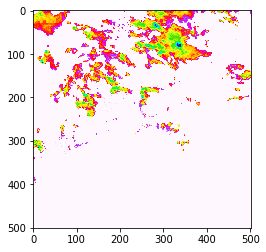

↓↓↓第0序列，第17次，下面的是模型的输出，上面的是真实值↑↑↑


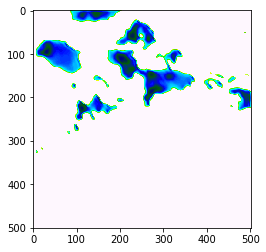


------------------------------------



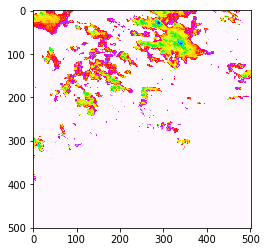

↓↓↓第0序列，第18次，下面的是模型的输出，上面的是真实值↑↑↑


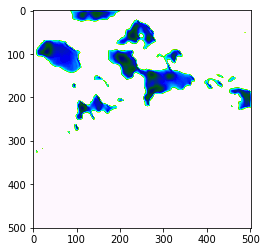


------------------------------------



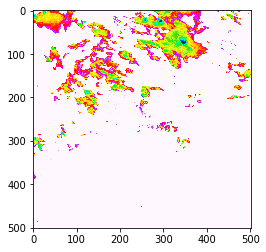

↓↓↓第0序列，第19次，下面的是模型的输出，上面的是真实值↑↑↑


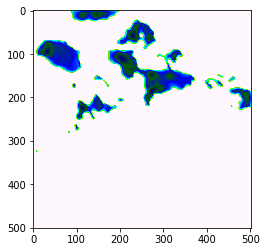


------------------------------------



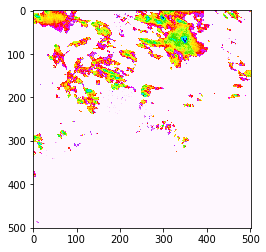

↓↓↓第0序列，第20次，下面的是模型的输出，上面的是真实值↑↑↑


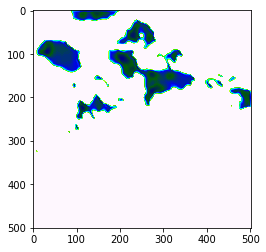


------------------------------------



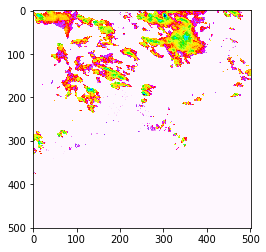

↓↓↓第0序列，第21次，下面的是模型的输出，上面的是真实值↑↑↑


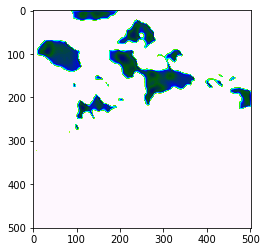


------------------------------------



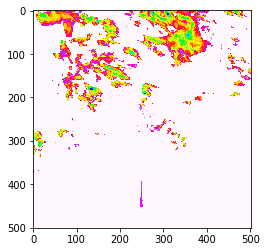

↓↓↓第0序列，第22次，下面的是模型的输出，上面的是真实值↑↑↑


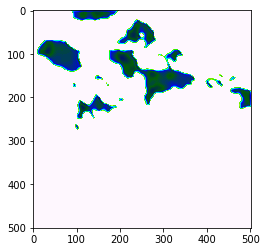


------------------------------------



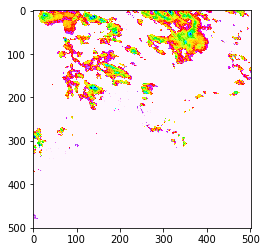

↓↓↓第0序列，第23次，下面的是模型的输出，上面的是真实值↑↑↑


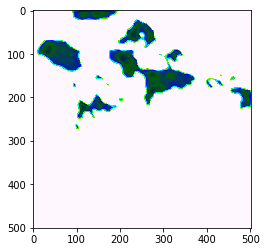


------------------------------------



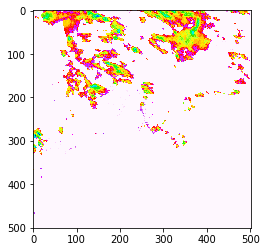

↓↓↓第0序列，第24次，下面的是模型的输出，上面的是真实值↑↑↑


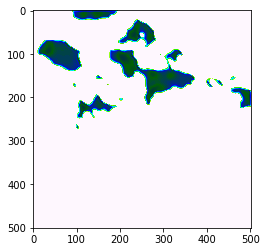


------------------------------------



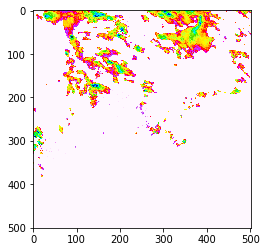

↓↓↓第0序列，第25次，下面的是模型的输出，上面的是真实值↑↑↑


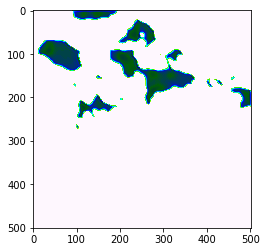


------------------------------------



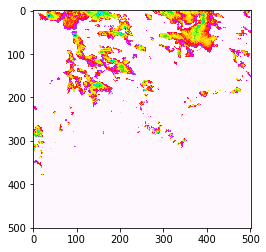

↓↓↓第0序列，第26次，下面的是模型的输出，上面的是真实值↑↑↑


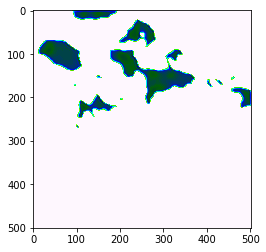


------------------------------------



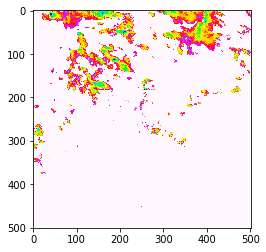

↓↓↓第0序列，第27次，下面的是模型的输出，上面的是真实值↑↑↑


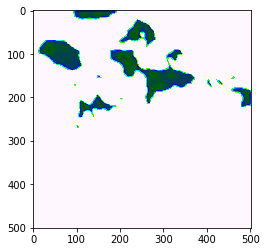


------------------------------------



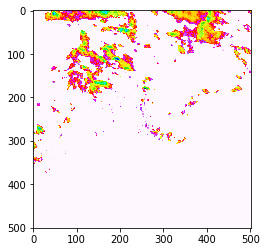

↓↓↓第0序列，第28次，下面的是模型的输出，上面的是真实值↑↑↑


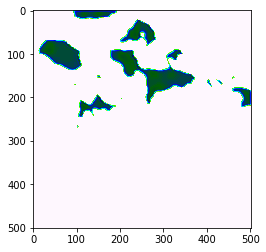


------------------------------------



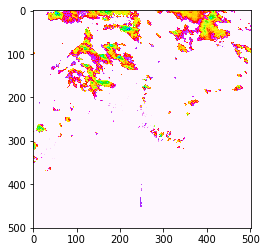

↓↓↓第0序列，第29次，下面的是模型的输出，上面的是真实值↑↑↑


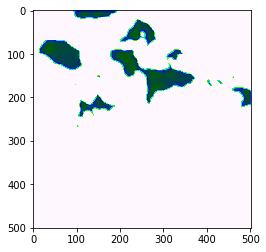


------------------------------------



In [62]:
for i in range(1):
    RAD_id = RAD_id_list[i]
    x_matrix = np.empty((31, 501, 501, 1))
    for k in range(30):
        x_matrix[k + 1] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, k))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
    prediction = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 30))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
    for j in range(30):
        for k in range(30):
            x_matrix[k] = x_matrix[k + 1]
        x_matrix[30] = prediction
        feed_dict = {x: [x_matrix]}
        prediction = sess.run(y, feed_dict=feed_dict)
        prediction = prediction[0] * SCALAR
        y_matrix = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 31 + j))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
        plt.imshow(y_matrix.reshape((501,501)), cmap=cm.gist_ncar_r)
        plt.show()
        print('↓↓↓第%d序列，第%d次，下面的是模型的输出，上面的是真实值↑↑↑' % (i, j))
        prediction = np.where(prediction<3, -1, prediction)
        plt.imshow(prediction.reshape((501,501)), cmap=cm.gist_ncar_r)
        plt.show()
        print('\n------------------------------------\n')
        prediction = prediction / SCALAR